<a href="https://colab.research.google.com/github/andregabrielmelo/license-plate-detection/blob/main/Jupyter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabalho M2

Alunos:
- Andre Gabriel de Melo
- Caio Furtado Rosa
- Jordan Lippert de Oliveira
- Lucas Bittencourt Rauch

Crie um sistema para localizar os caracteres de placas veículares utilizando as imagens do dataset disponibilizado e seguindo os critérios apresentados no enunciado do trabalho.

Abaixo estão códigos auxiliares para manipulação do dataset, visualização e cálculo de métricas.

Explore este notebook antes de iniciar o trabalho para um melhor aproveitamento do seu tempo.


In [16]:
from typing import Tuple
import matplotlib.pyplot as plt
import cv2

from models.label import Label
from dataclasses import dataclass


@dataclass
class Label:
    class_id: int
    center_y: float
    center_x: float
    height: float
    width: float

def draw_bboxes(
    img_rgb: cv2.Mat,
    labels: list[Label],
    color: Tuple,
    thickness: int = 2,
) -> cv2.Mat:
    img_copy = img_rgb.copy()
    h, w, _ = img_copy.shape

    for lbl in labels:
        cx = lbl.center_x
        cy = lbl.center_y
        bw = lbl.width
        bh = lbl.height

        # Converter coordenadas YOLO (cx,cy,bw,bh) -> (x_min,y_min,x_max,y_max)
        x_min = int((cx - bw / 2) * w)
        y_min = int((cy - bh / 2) * h)
        x_max = int((cx + bw / 2) * w)
        y_max = int((cy + bh / 2) * h)

        # Desenhar a bounding box
        cv2.rectangle(img_copy, (x_min, y_min), (x_max, y_max), color, thickness)

    return img_copy

# Parte principal

In [17]:
from pathlib import Path
import sys
from typing import List, Tuple
import numpy as np
import cv2

from helpers import debug_img, debug_img_individual, draw_bboxes
from models.label import Label

In [18]:
def localize_char_bbox(
    img: cv2.Mat, edge_method: str = "canny"
) -> Tuple[List[Label], List[dict]]:
    """
    Esta função localiza caracteres da placa usando métodos tradicionais e retorna
    bounding boxes normalizadas (YOLO-like).

    Notas para o aluno:
    1. Você provavelmente terá de testar diferentes métodos até encontrar um que
    melhor atenda a tarefa.
    2. Bounding boxes normalizadas (YOLO-like) significam que você terá que dividir
    o pixel em X pela largura da imagem e o pixel em Y pela altura da imagem
    """
    predictions: List[Label]

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Suavização para reduzir ruído
    blur = cv2.GaussianBlur(gray, (3, 3), 0)

    # TODO: Essas funções deveriam ajudar a aumentar a precisão da detecção de bordas. Descobrir a maneira correta de aplicar elas
    # Binarização (threshold adaptativo ou Otsu)
    high_thresh, thresh = cv2.threshold(
        blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )

    # Inverter se necessário (caracteres escuros em fundo claro)
    if np.mean(thresh) > 127:
        thresh = cv2.bitwise_not(thresh)

    # Remove little pieces
    # kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    # clean = cv2.morphologyEx(gray, cv2.MORPH_OPEN, kernel)
    # clean = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel)

    # TODO: Decobrir uma maeira melhor de selecionar o threshold utilizdo
    # Edge Detection
    if edge_method.lower() == "canny":
        edges = cv2.Canny(blur, high_thresh * 0.5, high_thresh)

    elif edge_method.lower() == "sobel":
        sobelx = cv2.Sobel(blur, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(blur, cv2.CV_64F, 0, 1, ksize=3)
        sobel = cv2.magnitude(sobelx, sobely)
        sobel = cv2.convertScaleAbs(sobel)
        _, edges = cv2.threshold(sobel, 120, 255, cv2.THRESH_BINARY)

    elif edge_method.lower() == "laplacian":
        laplacian = cv2.Laplacian(blur, cv2.CV_64F)
        laplacian = cv2.convertScaleAbs(laplacian)
        _, edges = cv2.threshold(laplacian, 100, 255, cv2.THRESH_BINARY)

    else:
        raise ValueError("Método inválido. Use 'canny', 'sobel' ou 'laplacian'.")

    combined = cv2.bitwise_or(thresh, edges)

    # TODO: Deve ser aplicado uma função para prevenção da junção das bordas

    # Contour Detection
    contours, hierarchy = cv2.findContours(
        combined, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )
    h_img, w_img = img.shape[:2]

    # TODO: Descobrir o porque as predições não estão corretas, mesmo pegado os contornos corretos de algumas imagens

    predictions = []
    for contour in contours:
        # TODO: Melhorar heuristica
        x, y, w, h = cv2.boundingRect(contour)

        # Heurísticas para filtrar caracteres
        if heuristic(contour, img):
            cx = (x + w / 2) / w_img
            cy = (y + h / 2) / h_img
            predictions.append(
                Label(
                    class_id=0,
                    center_x=cx,
                    center_y=cy,
                    width=w / w_img,
                    height=h / h_img,
                )
            )

    # 6. Ordenar da esquerda para direita (opcional)
    predictions.sort(key=lambda l: l.center_x)

    # # Make a copy of the original image to draw contours on
    img_contours = img.copy()
    cv2.drawContours(img_contours, contours, -1, (0, 255, 0), 1)
    img_contours_rgb = cv2.cvtColor(img_contours, cv2.COLOR_BGR2RGB)
    images_process = [
        {"image": gray, "title": "Grey"},
        {"image": blur, "title": "Blur"},
        {"image": thresh, "title": "Thresh binarização"},
        {"image": edges, "title": "Edges" + f" {edge_method}"},
        {"image": img_contours_rgb, "title": "Detected Contours"},
    ]


    return (predictions, images_process)

In [19]:
def heuristic(contour, img):
    x, y, w, h = cv2.boundingRect(contour)
    aspect_ratio = w / h
    area = w * h
    h_img, w_img = img.shape[:2]

    if 0.2 < aspect_ratio < 1.2 and 0.01 * h_img * w_img < area < 0.2 * h_img * w_img:
        return True
    else:
        return False

In [20]:
def load_data(dir_path: str):
    """
    Load image data from directory `data_dir`.

    Return tuple `(images, labels)`. `images` should be a list of all
    of the images in the data directory, where each image is formatted as a
    open cv MatLike. `labels` should be a list of with a list of labels,
    representing the list of labels for each of the corresponding `images`.
    Each image has one label per character in the license plate.
    """

    # Get path
    dataset_dir_path = Path(dir_path)
    images_file_path = list(dataset_dir_path.glob("*.png"))
    labels_file_path = list(dataset_dir_path.glob("*.txt"))

    # Sort
    images_file_path.sort()
    labels_file_path.sort()

    # Pega uma porcentagem do dataset
    # size = len(images_file_path)
    # images_file_path = images_file_path[0 : int(size * 0.1)]
    # labels_file_path = labels_file_path[0 : int(size * 0.1)]

    # Get images
    images: list[cv2.Mat] = []
    for file_path in images_file_path:
        image = cv2.imread(str(file_path), cv2.IMREAD_COLOR_RGB)
        images.append(image)

    # Get labels
    labels: list[list[Label]] = []
    for file_path in labels_file_path:
        file_labels = []
        with open(file_path, "r") as f:
            lines = f.readlines()
            for line in lines:
                cid, cx, cy, w, h = line.split(" ")
                file_labels.append(
                    Label(int(cid), float(cy), float(cx), float(h), float(w))
                )

        labels.append(file_labels)

    return (images, labels)

# Validação

In [21]:
import numpy as np

def compute_iou(bbox1, bbox2):
    """
    Calcula IoU entre dois retângulos (no formato YOLO normalizado).
    """
    # Converter para coordenadas absolutas [xmin, ymin, xmax, ymax]
    x1_min = bbox1.center_x - bbox1.width / 2
    y1_min = bbox1.center_y - bbox1.height / 2
    x1_max = bbox1.center_x + bbox1.width / 2
    y1_max = bbox1.center_y + bbox1.height / 2

    x2_min = bbox2.center_x - bbox2.width / 2
    y2_min = bbox2.center_y - bbox2.height / 2
    x2_max = bbox2.center_x + bbox2.width / 2
    y2_max = bbox2.center_y + bbox2.height / 2

    # Interseção
    inter_xmin = max(x1_min, x2_min)
    inter_ymin = max(y1_min, y2_min)
    inter_xmax = min(x1_max, x2_max)
    inter_ymax = min(y1_max, y2_max)

    inter_w = max(0, inter_xmax - inter_xmin)
    inter_h = max(0, inter_ymax - inter_ymin)
    inter_area = inter_w * inter_h

    # Áreas individuais
    area1 = (x1_max - x1_min) * (y1_max - y1_min)
    area2 = (x2_max - x2_min) * (y2_max - y2_min)

    # IoU
    union = area1 + area2 - inter_area
    return inter_area / union if union > 0 else 0


def evaluate_iou(detected_labels, true_labels, iou_threshold=0.5):
    """
    Calcula métricas médias de IoU e taxa de acerto (detections corretas).
    """
    ious = []
    matched = 0

    for det in detected_labels:
        best_iou = 0
        for gt in true_labels:
            iou = compute_iou(det, gt)
            best_iou = max(best_iou, iou)
        ious.append(best_iou)
        if best_iou >= iou_threshold:
            matched += 1

    mean_iou = np.mean(ious) if ious else 0
    precision = matched / len(detected_labels) if detected_labels else 0
    recall = matched / len(true_labels) if true_labels else 0

    return {"mean_iou": float(mean_iou), "precision": precision, "recall": recall}




# Visualização


Gere abaixo alguns exemplos de predições do seu método e compare com as respostas esperadas e as respostas do método exemplo

In [22]:
def debug_img(images):
    ncols = len(images)
    f, axarr = plt.subplots(1, ncols, figsize=(4 * ncols, 4))

    # Intermediate steps from localize_char_bbox
    for i, step in enumerate(images):
        axarr[i].imshow(
            step["image"], cmap="gray" if len(step["image"].shape) == 2 else None
        )
        axarr[i].set_title(step["title"])
        axarr[i].axis("off")

    plt.tight_layout()
    plt.show()


# Execução principal


Código com execução principal, para rodar os demais códgios e calcular as médias de precisão

In [23]:
def main():
    # Check command-line arguments
    datasetPath = "dataset"
        
    # Get image arrays and labels for all image files
    images, labels = load_data(datasetPath)

    # Evaluate precision
    mean_iou = 0
    mean_precision = 0
    mean_recall = 0

    for index, img, label in zip(range(len(images)), images, labels):
        # Localize the caharacters of the licese plate in the image
        predictions, image_process = localize_char_bbox(img)

        metrics = evaluate_iou(predictions, label)
        # print(f"{index} Cannny metrics:", metrics)

        # If precision is too low, try fallback methods
        if metrics["precision"] < 0.1:
            # Try Laplacian
            lap_preds, lap_images = localize_char_bbox(img, edge_method="laplacian")
            lap_metrics = evaluate_iou(lap_preds, label)
            # print("Lapl   acian metrics:", lap_metrics)

            # Try Sobel
            sobel_preds, sobel_images = localize_char_bbox(img, edge_method="sobel")
            sobel_metrics = evaluate_iou(sobel_preds, label)
            # print("Sobel metrics:", sobel_metrics)

            # Pick best fallback by precision
            best_method = "laplacian"
            best_preds = lap_preds
            best_images = lap_images
            best_metrics = lap_metrics

            if sobel_metrics["precision"] > best_metrics["precision"]:
                best_method = "sobel"
                best_preds = sobel_preds
                best_images = sobel_images
                best_metrics = sobel_metrics

            # Use best fallback if better than Canny
            if best_metrics["precision"] > metrics["precision"]:
                predictions = best_preds
                image_process = best_images
                metrics = best_metrics
                # print(f"Using fallback method: {best_method}")

        imgdraw = draw_bboxes(img, label, color=(0, 255, 0), thickness=1)
        imgdraw = draw_bboxes(imgdraw, predictions, color=(255, 0, 0), thickness=1)

        image_process.append({"image": img, "title": "Original"})
        image_process.append({"image": imgdraw, "title": "Detected"})

        # Pegar imagens para relatório
        if (
            index == 0
        ):
            debug_img(image_process)

        mean_iou += metrics["mean_iou"]
        mean_precision += metrics["precision"]
        mean_recall += metrics["recall"]

    n_samples = len(images)
    print()
    print(f"Mean IoU: {mean_iou / n_samples}")
    print(f"Mean precision: {mean_precision / n_samples}")
    print(f"Mean recall: {mean_recall / n_samples}")

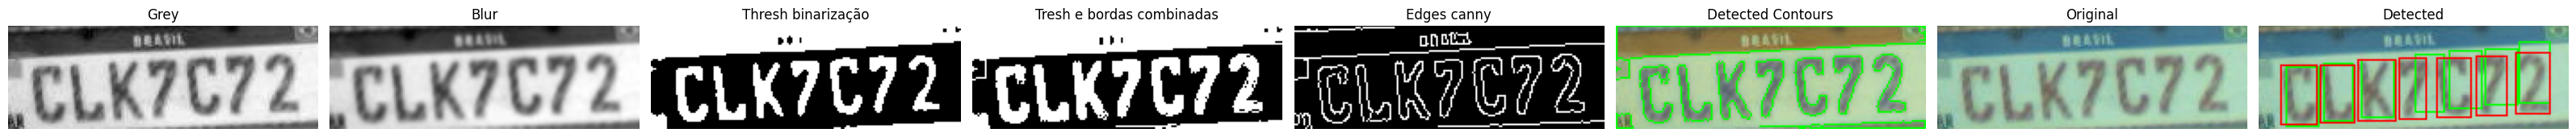


Mean IoU: 0.42938327581206753
Mean precision: 0.27210884353741494
Mean recall: 0.18367346938775508


In [24]:
main()

# Relatório

Detalhes do funcionamento do algortimo:

Antes de realizarmos a detectção de bordas, aplicamos os seguintes tratamentos na imagem:
1. Começamos convertendo a imagem para tons de cinza
2. Aplicamos um filtro de blur
3. Aplicamos um treshhold para binarmizarmos a imagem com apenas as cores preto e branco
4. Aplicado o algoritmo de detecção de bordas de canny

A partir desse ponto, temos uma imagem filtrada apenas com as bordas amostra, onde o fundo é 100% preto, e as bordas são 100% brancas
Com base nas bordas, iremos detectar as caixas onde ficam os digitos da placa, para isso, fazemos os seguintes passos:
1. Usamos a função findContours do CV2 para detectar as bordas da imagem com base na imagem de canny
2. Para cada contorno detectado, usamos a função boundRect para pegarmos as coordendas X,Y e as dimensões de largura e altura de cada contorno
3. A função heuristics analisa as proporções a dimensão da borda, e com base nisso, determina se essa borda é ou não referente a um digito da placa
4. De todos os contornos da imagem, filtramos apenas aqueles que possuem uma heurisitca true
5. Por fim, retornamos todas as bordas filtradas.